# Import Azure Quantum

In [2]:
from azure.quantum import Workspace
workspace = Workspace (
   resource_id = "/subscriptions/e0d51919-2dda-4b7e-a8e7-77cc18580acb/resourceGroups/AzureQuantum/providers/Microsoft.Quantum/Workspaces/QECBenchmarking",
   location = "uksouth"
)

from azure.quantum.qiskit import AzureQuantumProvider
provider = AzureQuantumProvider(workspace)
backend_est = provider.get_backend('microsoft.estimator')

# Ising model

In [1]:
from qiskit.quantum_info import SparsePauliOp
from math import sin, cos


def get_hamiltonian(L, J, h, alpha=0):

    # List of Hamiltonian terms as 3-tuples containing
    # (1) the Pauli string,
    # (2) the qubit indices corresponding to the Pauli string,
    # (3) the coefficient.
    ZZ_tuples = [("ZZ", [i, i + 1], -J) for i in range(0, L - 1)]
    Z_tuples = [("Z", [i], -h * sin(alpha)) for i in range(0, L)]
    X_tuples = [("X", [i], -h * cos(alpha)) for i in range(0, L)]

    # We create the Hamiltonian as a SparsePauliOp, via the method
    # `from_sparse_list`, and multiply by the interaction term.
    hamiltonian = SparsePauliOp.from_sparse_list([*ZZ_tuples, *Z_tuples, *X_tuples], num_qubits=L)
    return hamiltonian.simplify()

In [2]:
from math import pi

H = get_hamiltonian(L=4, J=0.2, h=1.0, alpha=pi / 8)
H

SparsePauliOp(['IIZZ', 'IZZI', 'ZZII', 'IIIZ', 'IIZI', 'IZII', 'ZIII', 'IIIX', 'IIXI', 'IXII', 'XIII'],
              coeffs=[-0.2       +0.j, -0.2       +0.j, -0.2       +0.j, -0.38268343+0.j,
 -0.38268343+0.j, -0.38268343+0.j, -0.38268343+0.j, -0.92387953+0.j,
 -0.92387953+0.j, -0.92387953+0.j, -0.92387953+0.j])

In [3]:
from qiskit.quantum_info import Statevector
from qiskit_algorithms import TimeEvolutionProblem
from qiskit_algorithms import TrotterQRTE

final_time = 1.6

# First spin up, second spin down
# (remember that the labels are interpreted from right to left)
initial_state = Statevector.from_label("0000")

problem = TimeEvolutionProblem(H, initial_state=initial_state, time=final_time)
trotter = TrotterQRTE()
result = trotter.evolve(problem)

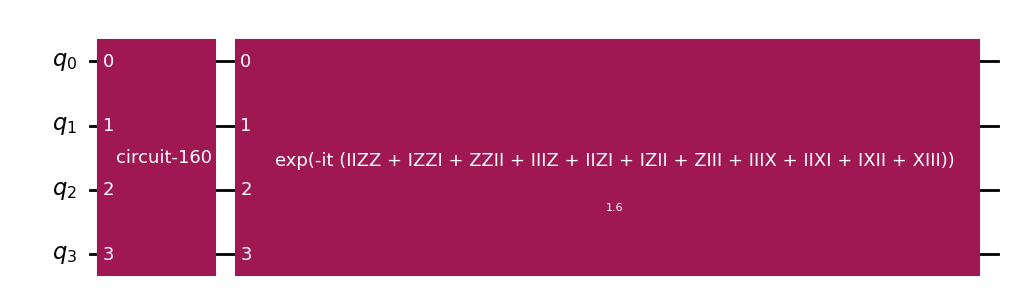

In [5]:
result.evolved_state.draw("mpl")

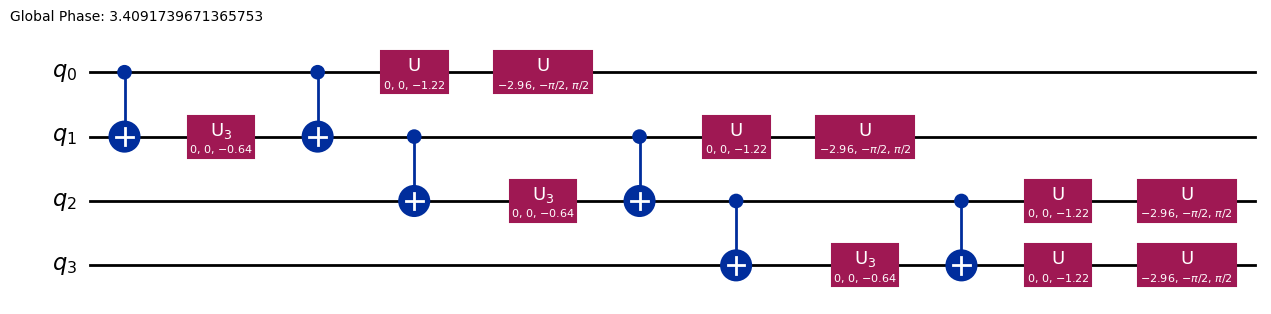

In [10]:
result.evolved_state.decompose(reps=3).decompose().decompose().draw("mpl")

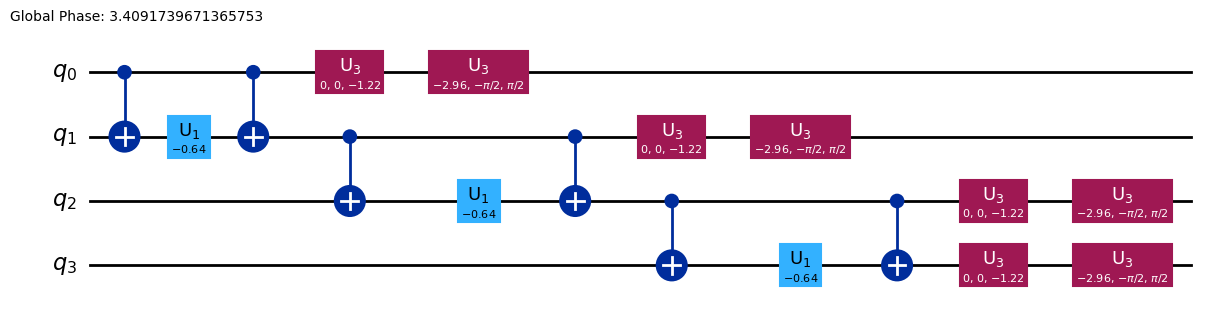

In [11]:
result.evolved_state.decompose(reps=2).decompose().decompose().draw("mpl")

In [7]:
statevector = Statevector(result.evolved_state)
print(statevector)

Statevector([-7.04724483e-05-1.93204394e-05j,
              2.08072045e-04-7.58955121e-04j,
              2.08072045e-04-7.58955121e-04j,
              8.17358969e-03+2.24083806e-03j,
              2.08072045e-04-7.58955121e-04j,
              8.17358969e-03+2.24083806e-03j,
              8.17358969e-03+2.24083806e-03j,
             -2.41327719e-02+8.80257165e-02j,
              2.08072045e-04-7.58955121e-04j,
              8.17358969e-03+2.24083806e-03j,
              8.17358969e-03+2.24083806e-03j,
             -2.41327719e-02+8.80257165e-02j,
              8.17358969e-03+2.24083806e-03j,
             -2.41327719e-02+8.80257165e-02j,
             -2.41327719e-02+8.80257165e-02j,
             -9.47995565e-01-2.59898603e-01j],
            dims=(2, 2, 2, 2))


In [8]:
# import numpy as np
# import matplotlib.pyplot as plt

# bar_width = 0.1
# # We prepare an initial state ↑↓ (01).
# # Note that Statevector and SparsePauliOp interpret the qubits from right to left
# initial_state = Statevector.from_label("10")
# trotter = TrotterQRTE()
# final_time = 1.6
# eps = 1e-5

# # We create the list of angles in radians, with a small epsilon
# # the exactly longitudinal field, which would present no dynamics at all
# alphas = np.linspace(-np.pi / 2 + eps, np.pi / 2 - eps, 5)

# for i, alpha in enumerate(alphas):
#     H_alpha = get_hamiltonian(L=2, J=0.2, h=1.0, alpha=alpha)
#     problem = TimeEvolutionProblem(H_alpha, initial_state=initial_state, time=1.6)
#     result = trotter.evolve(problem)
#     evolved_state = Statevector(result.evolved_state)
#     # Dictionary of probabilities
#     amplitudes_dict = evolved_state.probabilities_dict()
#     labels = list(amplitudes_dict.keys())
#     values = list(amplitudes_dict.values())
#     # Convert angle to degrees
#     alpha_str = f"$\\alpha={int(np.round(alpha * 180 / pi))}^\\circ$"
#     plt.bar(np.arange(4) + i * bar_width, values, bar_width, label=alpha_str, alpha=0.7)

# plt.xticks(np.arange(4) + 2 * bar_width, labels)
# plt.xlabel("Measurement")
# plt.ylabel("Probability")
# plt.suptitle(
#     f"Measurement probabilities at $t={final_time}$, for various field angles $\\alpha$\n"
#     f"Initial state: 10, Linear lattice of size $L=2$"
# )
# plt.legend()


Trotter step with Lie-Trotter
-----------------------------

                  Depth: 5
             Gate count: 11
    Nonlocal gate count: 3
         Gate breakdown: RZ: 4, RX: 4, RZZ: 3



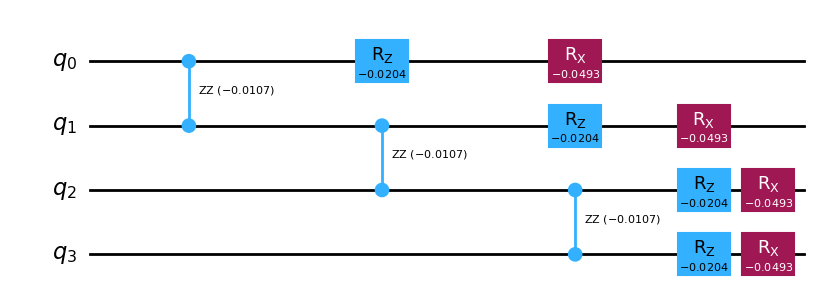

In [8]:
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import LieTrotter

num_timesteps = 60
dt = final_time / num_timesteps
trotter_step_first_order = PauliEvolutionGate(H, dt, synthesis=LieTrotter())

# We create an empty circuit
circuit = QuantumCircuit(H.num_qubits)
circuit.append(trotter_step_first_order, range(H.num_qubits))
circuit = circuit.decompose(reps=2)

# Let us print some stats
print(
    f"""
Trotter step with Lie-Trotter
-----------------------------

                  Depth: {circuit.depth()}
             Gate count: {len(circuit)}
    Nonlocal gate count: {circuit.num_nonlocal_gates()}
         Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in circuit.count_ops().items()])}
"""
)

# And finally draw the circuit
circuit.draw("mpl")


Trotter step with Suzuki Trotter (2nd order)
--------------------------------------------

                  Depth: 10
             Gate count: 21
    Nonlocal gate count: 6
         Gate breakdown: RZ: 8, RX: 7, RZZ: 6




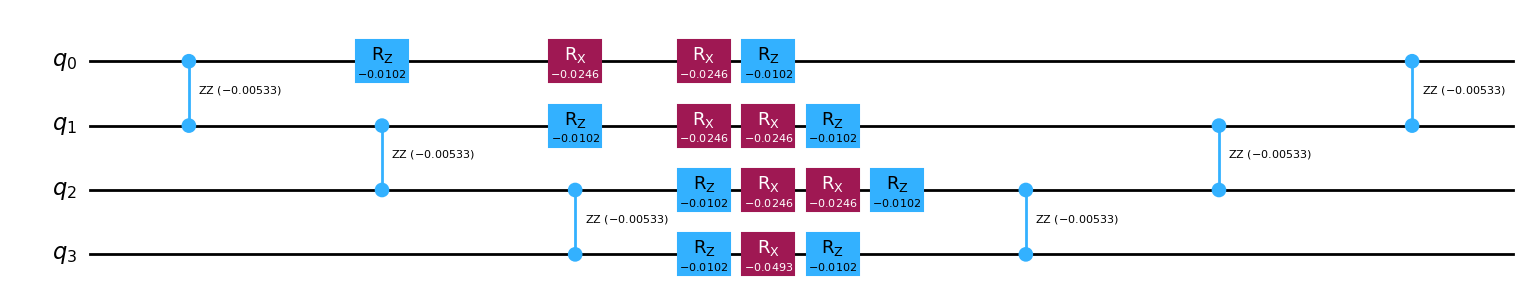

In [9]:
from qiskit.synthesis import SuzukiTrotter

second_order_formula = SuzukiTrotter()  # if not passed, order defaults to 2
trotter_step_second_order = PauliEvolutionGate(H, dt, synthesis=second_order_formula)
circuit = QuantumCircuit(H.num_qubits)
circuit.append(trotter_step_second_order, range(H.num_qubits))
circuit = circuit.decompose(reps=2)

# Let us print some stats
print(
    f"""
Trotter step with Suzuki Trotter (2nd order)
--------------------------------------------

                  Depth: {circuit.depth()}
             Gate count: {len(circuit)}
    Nonlocal gate count: {circuit.num_nonlocal_gates()}
         Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in circuit.count_ops().items()])}

"""
)

circuit.draw("mpl")

# Observable

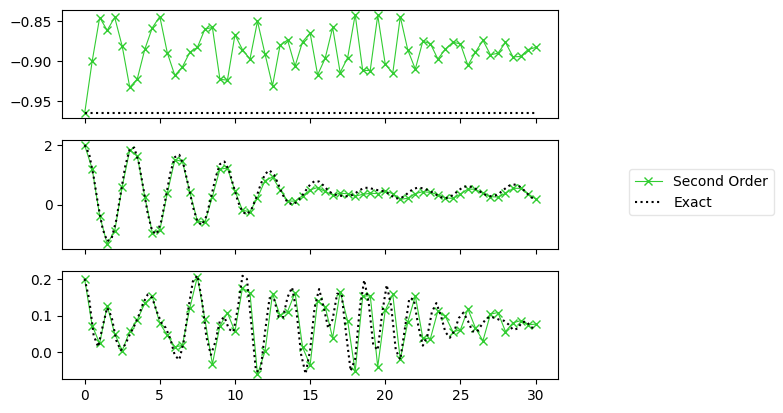

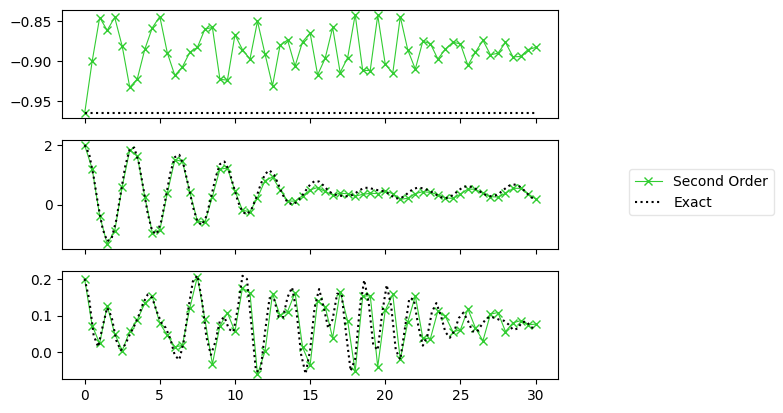

In [10]:
from qiskit.synthesis import SuzukiTrotter
from qiskit.primitives import Estimator
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc

L = 6
H = get_hamiltonian(L=L, J=0.2, h=1.0, alpha=pi / 8)
final_time = 30.0
initial_state = Statevector.from_label("001100")

magnetization_op = SparsePauliOp.from_sparse_list(
    [("Z", [i], 1.0) for i in range(0, L)], num_qubits=L
)
correlation_op = SparsePauliOp.from_sparse_list(
    [("ZZ", [i, i + 1], 1.0) for i in range(0, L - 1)], num_qubits=L
) / (L - 1)

trotter = TrotterQRTE(SuzukiTrotter(order=2), num_timesteps=num_timesteps, estimator=Estimator())
problem = TimeEvolutionProblem(
    H,
    initial_state=initial_state,
    time=final_time,
    aux_operators=[H, magnetization_op, correlation_op],
)
result = trotter.evolve(problem)
observables_order2 = np.array(np.array(result.observables)[:, :, 0], dtype=np.float64)

H_array = H.to_matrix()

# We define a slightly denser time mesh
exact_times = np.linspace(0, final_time, 101)

# We compute the exact evolution using the exp
exact_evolution = [
    initial_state.evolve(sc.linalg.expm(-1j * time * H_array)) for time in exact_times
]

exact_energy = np.real([sv.expectation_value(H) for sv in exact_evolution])
exact_magnetization = np.real([sv.expectation_value(magnetization_op) for sv in exact_evolution])
exact_correlation = np.real([sv.expectation_value(correlation_op) for sv in exact_evolution])

fig, axes = plt.subplots(3, sharex=True)
times = np.linspace(0, final_time, num_timesteps + 1)  # includes initial state

axes[0].plot(
    times, observables_order2[:, 0], label="Second Order", marker="x", c="limegreen", ls="-", lw=0.8
)
axes[1].plot(
    times, observables_order2[:, 1], label="Second Order", marker="x", c="limegreen", ls="-", lw=0.8
)
axes[2].plot(
    times, observables_order2[:, 2], label="Second Order", marker="x", c="limegreen", ls="-", lw=0.8
)

axes[0].plot(exact_times, exact_energy, c="k", ls=":", label="Exact")
axes[1].plot(exact_times, exact_magnetization, c="k", ls=":", label="Exact")
axes[2].plot(exact_times, exact_correlation, c="k", ls=":", label="Exact")

legend = fig.legend(
    *axes[0].get_legend_handles_labels(),
    bbox_to_anchor=(1.0, 0.5),
    loc="center left",
    framealpha=0.5,
)
fig

# Higher order


Trotter step with Suzuki Trotter (2nd order)
--------------------------------------------

                  Depth: 14
             Gate count: 33
    Nonlocal gate count: 10
         Gate breakdown: RZ: 12, RX: 11, RZZ: 10




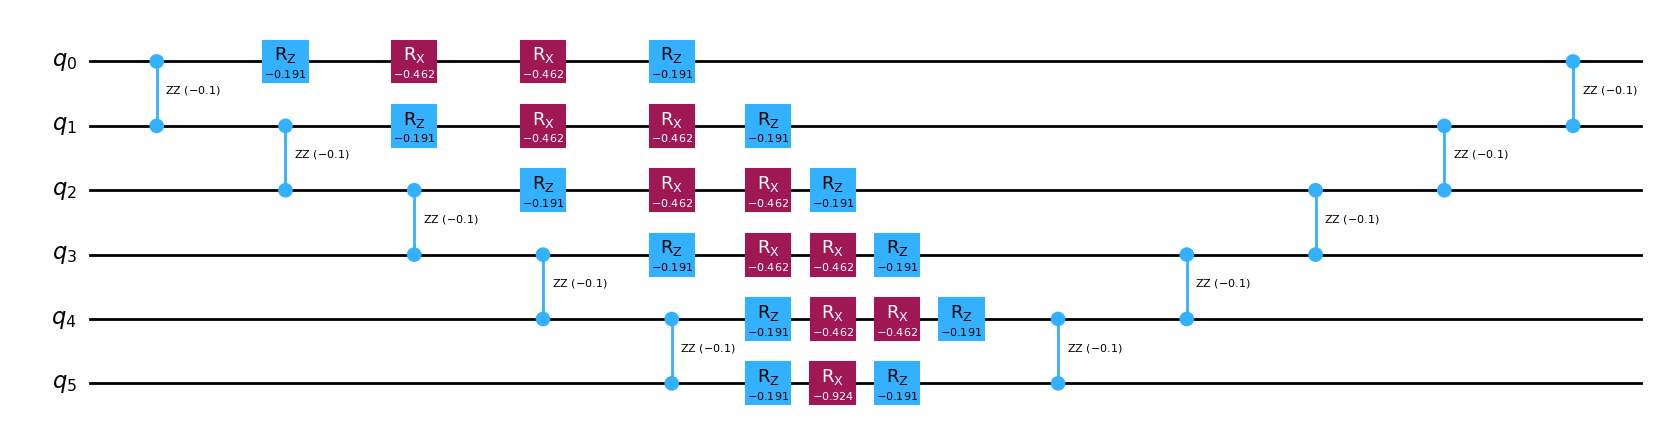

In [99]:
second_order_formula = SuzukiTrotter()

L = 6
H = get_hamiltonian(L=L, J=0.2, h=1.0, alpha=pi / 8)
final_time = 30.0
num_timesteps = 60
dt = final_time / num_timesteps
initial_state = Statevector.from_label("001100")

trotter_step_second_order = PauliEvolutionGate(H, dt, synthesis=second_order_formula)
circuit = QuantumCircuit(H.num_qubits)
circuit.append(trotter_step_second_order, range(H.num_qubits))
circuit = circuit.decompose(reps=2)

# Let us print some stats
print(
    f"""
Trotter step with Suzuki Trotter (2nd order)
--------------------------------------------

                  Depth: {circuit.depth()}
             Gate count: {len(circuit)}
    Nonlocal gate count: {circuit.num_nonlocal_gates()}
         Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in circuit.count_ops().items()])}

"""
)

circuit.draw("mpl")


Trotter step with Suzuki Trotter (4th order)
--------------------------------------------

                  Depth: 70
             Gate count: 165
    Nonlocal gate count: 50
         Gate breakdown: RZ: 60, RX: 55, RZZ: 50




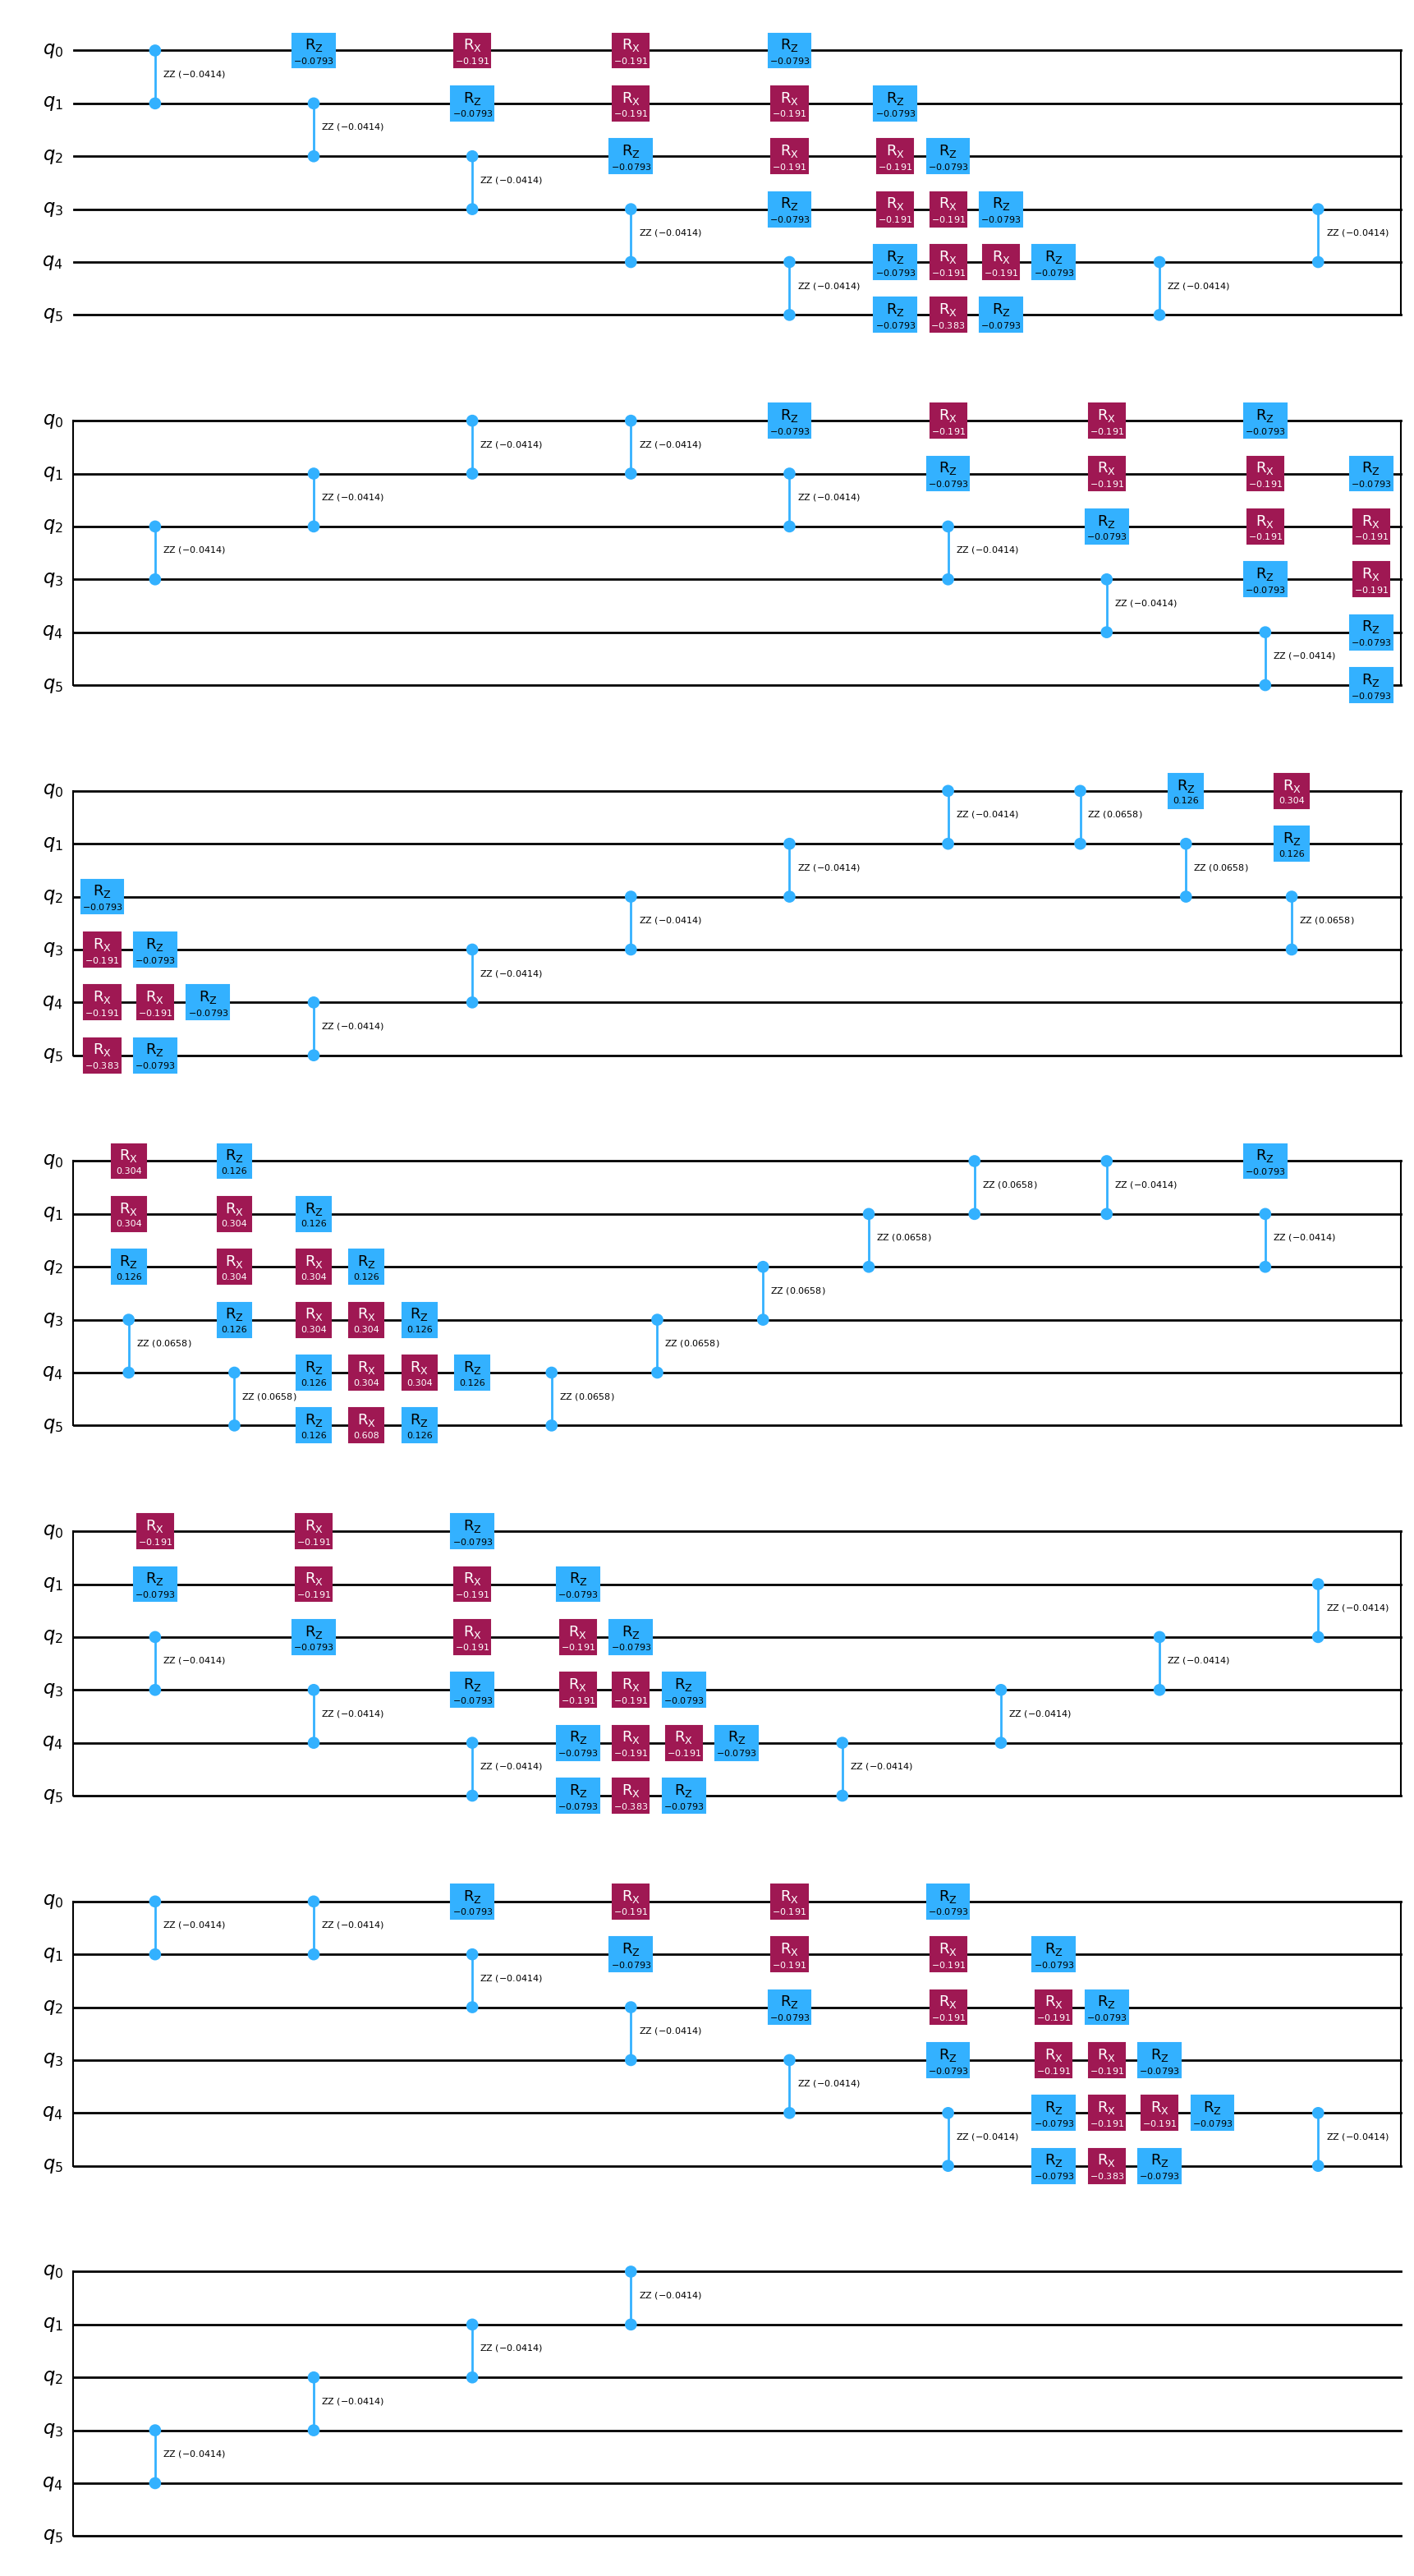

In [39]:
fourth_order_formula = SuzukiTrotter(order=4)
trotter_step_fourth_order = PauliEvolutionGate(H, dt, synthesis=fourth_order_formula)
circuit4 = QuantumCircuit(H.num_qubits)
circuit4.append(trotter_step_fourth_order, range(H.num_qubits))
circuit4 = circuit4.decompose(reps=2)

# Let us print some stats
print(
    f"""
Trotter step with Suzuki Trotter (4th order)
--------------------------------------------

                  Depth: {circuit4.depth()}
             Gate count: {len(circuit4)}
    Nonlocal gate count: {circuit4.num_nonlocal_gates()}
         Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in circuit4.count_ops().items()])}

"""
)

circuit4.draw("mpl")

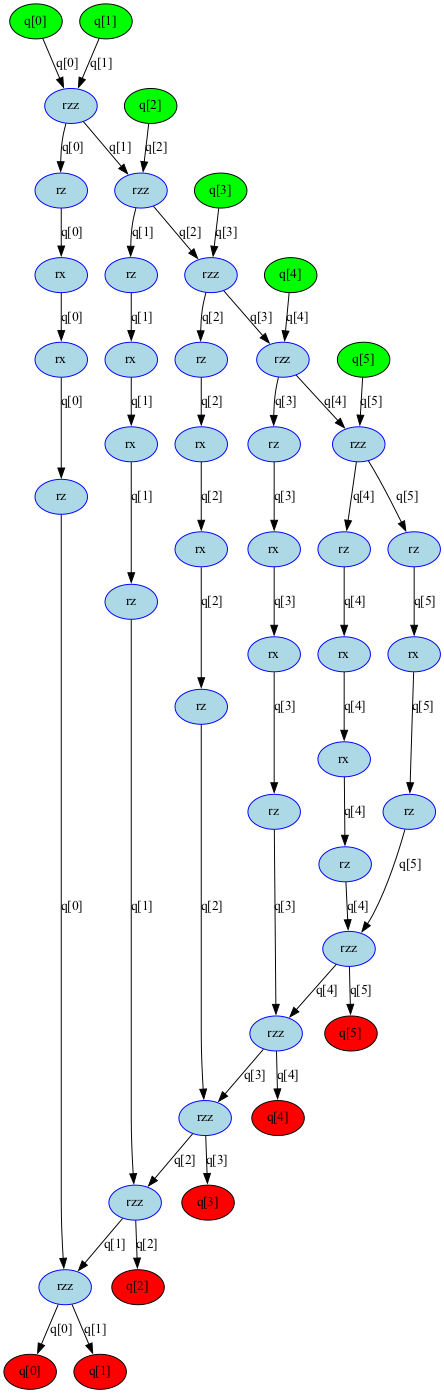

In [12]:
from qiskit.converters import circuit_to_dag
DAG = circuit_to_dag(circuit)
DAG.draw()

In [14]:
# trotter_step_second_order = PauliEvolutionGate(H, dt, synthesis=second_order_formula)
# circuit = QuantumCircuit(H.num_qubits)
# circuit.append(trotter_step_second_order, range(H.num_qubits))
# c2 = circuit.decompose(reps=2)
# c2.draw("mpl")

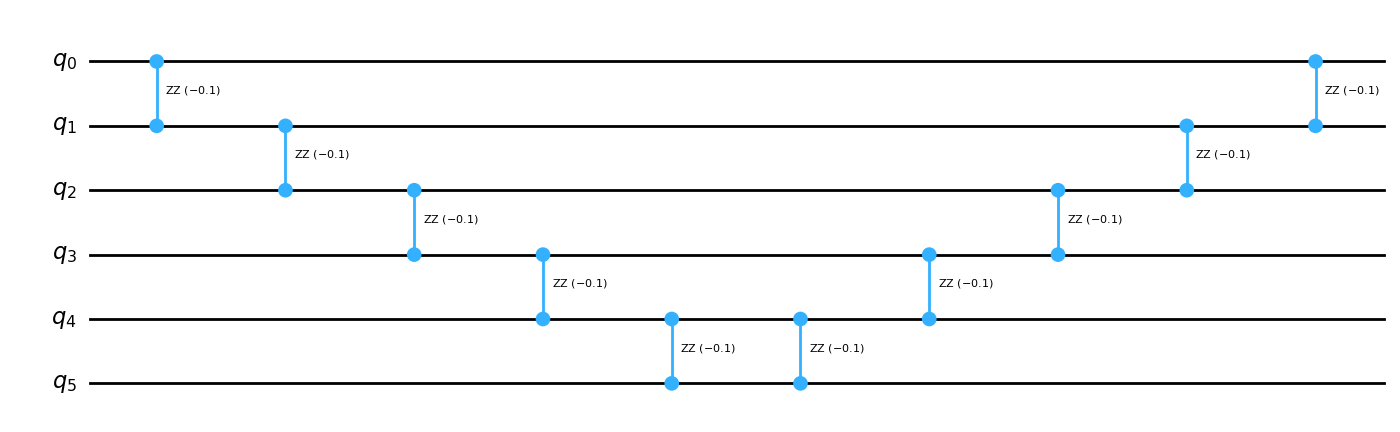

In [13]:
c2 = circuit.copy()
c2.data = [instruction for instruction in circuit.data if instruction.operation.num_qubits>1]
c2.draw("mpl")

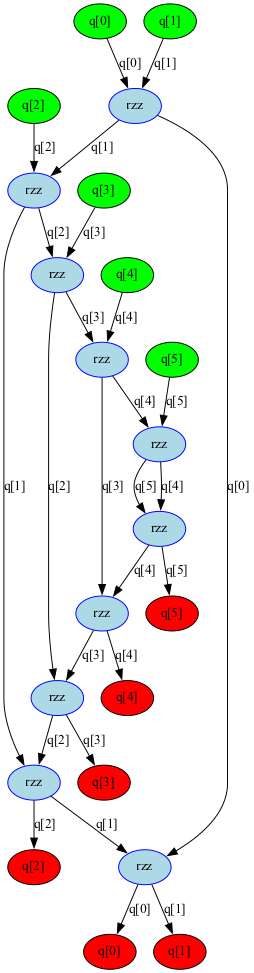

In [14]:
DAG2 = circuit_to_dag(c2)
DAG2.draw()

CutQC

In [ ]:
# from circuit_knitting.cutting.cutqc import cut_circuit_wires

# cuts = cut_circuit_wires(
#     circuit=circuit,
#     method="automatic",
#     max_subcircuit_width=5,
#     max_cuts=2,
#     num_subcircuits=[2],
# )

# Auto Cut

In [60]:
magnetization_op

SparsePauliOp(['IIIIIZ', 'IIIIZI', 'IIIZII', 'IIZIII', 'IZIIII', 'ZIIIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])

Found solution using 2 cuts with a sampling overhead of 2.071298110588719.
Gate Cut at circuit instruction index 15
Gate Cut at circuit instruction index 29


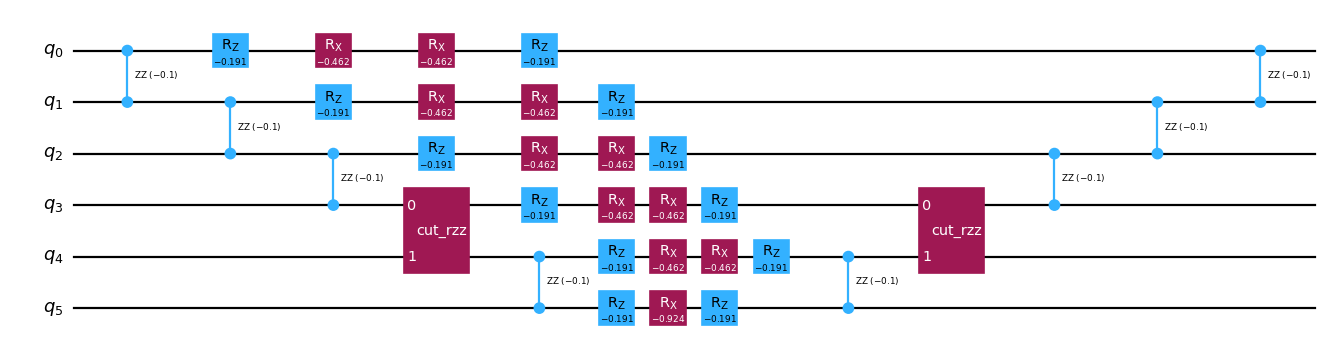

In [61]:
observable = SparsePauliOp(['IIIIIZ', 'IIIIZI', 'IIIZII', 'IIZIII', 'IZIIII', 'ZIIIII'])

from circuit_knitting.cutting.automated_cut_finding import (
    find_cuts,
    OptimizationParameters,
    DeviceConstraints,
)

# Specify settings for the cut-finding optimizer
optimization_settings = OptimizationParameters(seed=111)

# Specify the size of the QPUs available
device_constraints = DeviceConstraints(qubits_per_subcircuit=4)

cut_circuit, metadata = find_cuts(circuit, optimization_settings, device_constraints)
print(
    f'Found solution using {len(metadata["cuts"])} cuts with a sampling '
    f'overhead of {metadata["sampling_overhead"]}.'
)
for cut in metadata["cuts"]:
    print(f"{cut[0]} at circuit instruction index {cut[1]}")
cut_circuit.draw("mpl", scale=0.8, fold=-1)

Add ancillas for wire cuts and expand the observables to account for ancilla qubits

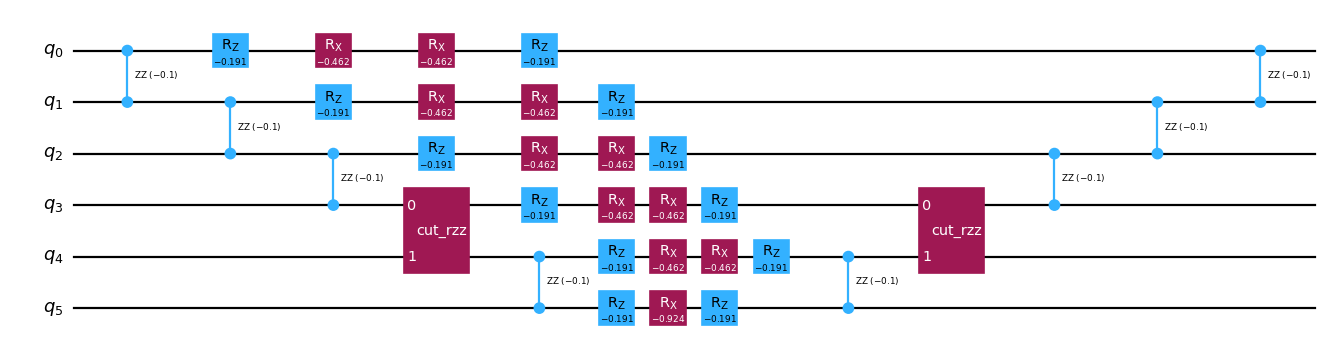

In [62]:
from circuit_knitting.cutting import cut_wires, expand_observables

qc_w_ancilla = cut_wires(cut_circuit)
observables_expanded = expand_observables(observable.paulis, circuit, qc_w_ancilla)
qc_w_ancilla.draw("mpl", scale=0.8, fold=-1)

Partition the circuit and observables into subcircuits and subobservables. Calculate the sampling overhead incurred from cutting these gates and wires.

In [63]:
from circuit_knitting.cutting import partition_problem

partitioned_problem = partition_problem(
    circuit=qc_w_ancilla, observables=observables_expanded
)
subcircuits = partitioned_problem.subcircuits
subobservables = partitioned_problem.subobservables
print(
    f"Sampling overhead: {np.prod([basis.overhead for basis in partitioned_problem.bases])}"
)

Sampling overhead: 2.071298110588719


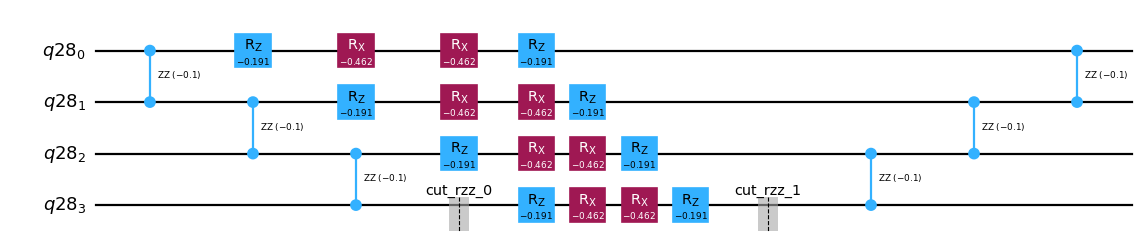

In [41]:
subcircuits[0].draw("mpl", style="iqp", scale=0.8)

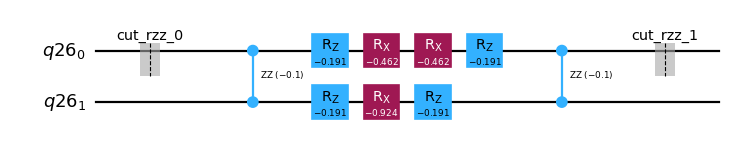

In [18]:
subcircuits[1].draw("mpl", style="iqp", scale=0.8)

In [64]:
from circuit_knitting.cutting import generate_cutting_experiments

subexperiments, coefficients = generate_cutting_experiments(
    circuits=subcircuits, observables=subobservables, num_samples=1_000
)
print(
    f"{len(subexperiments[0]) + len(subexperiments[1])} total subexperiments to run on backend."
)
print(coefficients)

56 total subexperiments to run on backend.
[(0.9950104048691675, <WeightType.EXACT: 1>), (0.04979202051108966, <WeightType.EXACT: 1>), (-0.04979202051108966, <WeightType.EXACT: 1>), (0.04979202051108966, <WeightType.EXACT: 1>), (-0.04979202051108966, <WeightType.EXACT: 1>), (0.04979202051108966, <WeightType.EXACT: 1>), (-0.04979202051108966, <WeightType.EXACT: 1>), (0.04979202051108966, <WeightType.EXACT: 1>), (-0.04979202051108966, <WeightType.EXACT: 1>), (0.002491677769844795, <WeightType.EXACT: 1>), (0.002491677769844795, <WeightType.EXACT: 1>), (0.002491677769844794, <WeightType.EXACT: 1>), (-0.002491677769844794, <WeightType.EXACT: 1>), (0.002491677769844794, <WeightType.EXACT: 1>), (-0.002491677769844794, <WeightType.EXACT: 1>), (-0.002491677769844794, <WeightType.EXACT: 1>), (0.002491677769844794, <WeightType.EXACT: 1>), (-0.002491677769844794, <WeightType.EXACT: 1>), (0.002491677769844794, <WeightType.EXACT: 1>), (0.002491677769844794, <WeightType.EXACT: 1>), (-0.00249167776984

In [65]:
from qiskit_ibm_runtime.fake_provider import FakeManilaV2

backend = FakeManilaV2()

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Transpile the subexperiments to ISA circuits
pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)
isa_subexperiments = {
    label: pass_manager.run(partition_subexpts)
    for label, partition_subexpts in subexperiments.items()
}

from qiskit_ibm_runtime import SamplerV2, Batch

# Submit each partition's subexperiments to the Qiskit Runtime Sampler
# primitive, in a single batch so that the jobs will run back-to-back.
with Batch(backend=backend) as batch:
    sampler = SamplerV2(mode=batch)
    jobs = {
        label: sampler.run(subsystem_subexpts, shots=2**12)
        for label, subsystem_subexpts in isa_subexperiments.items()
    }

# Retrieve results
result_overall = {label: job.result() for label, job in jobs.items()}

In [66]:
from circuit_knitting.cutting import reconstruct_expectation_values

reconstructed_expvals = reconstruct_expectation_values(
    result_overall,
    coefficients,
    subobservables,
)
final_expval = np.dot(reconstructed_expvals, observable.coeffs)

from qiskit_aer.primitives import EstimatorV2

estimator = EstimatorV2()
exact_expval = estimator.run([(circuit, observable)]).result()[0].data.evs
print(f"Reconstructed expectation value: {np.real(np.round(final_expval, 8))}")
print(f"Exact expectation value: {np.round(exact_expval, 8)}")
print(f"Error in estimation: {np.real(np.round(final_expval-exact_expval, 8))}")
print(
    f"Relative error in estimation: {np.real(np.round((final_expval-exact_expval) / exact_expval, 8))}"
)

Reconstructed expectation value: 3.45528647
Exact expectation value: 3.61637426
Error in estimation: -0.16108779
Relative error in estimation: -0.044544


# Manual Cut

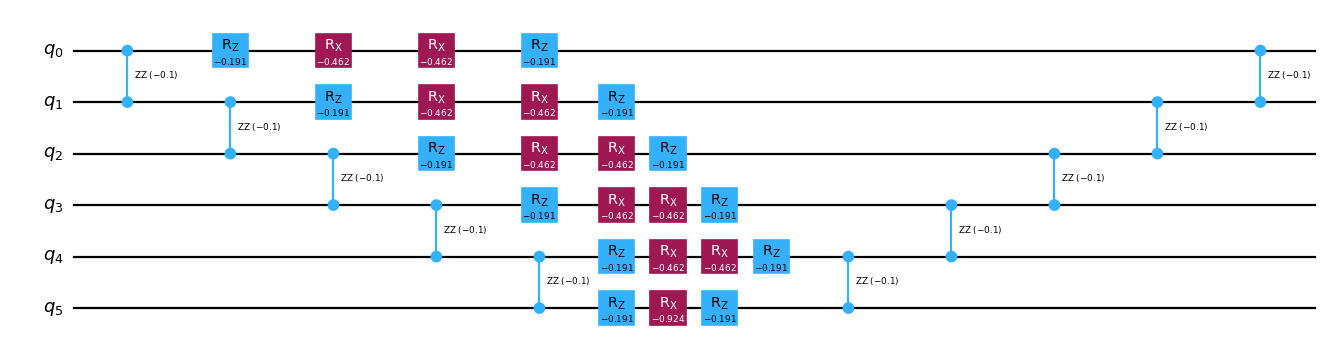

In [100]:
from circuit_knitting.cutting.instructions import CutWire
from circuit_knitting.cutting import cut_wires, expand_observables
circuit.draw("mpl", scale=0.8, fold=-1)

In [107]:
[instruction.operation.name for instruction in circuit.copy().data]

['rzz',
 'rz',
 'rx',
 'rx',
 'rz',
 'rzz',
 'rz',
 'rx',
 'rx',
 'rz',
 'rzz',
 'rz',
 'rx',
 'rx',
 'rz',
 'rzz',
 'rz',
 'rx',
 'rx',
 'rz',
 'rzz',
 'rz',
 'rx',
 'rx',
 'rz',
 'rz',
 'rx',
 'rz',
 'rzz',
 'rzz',
 'rzz',
 'rzz',
 'rzz']

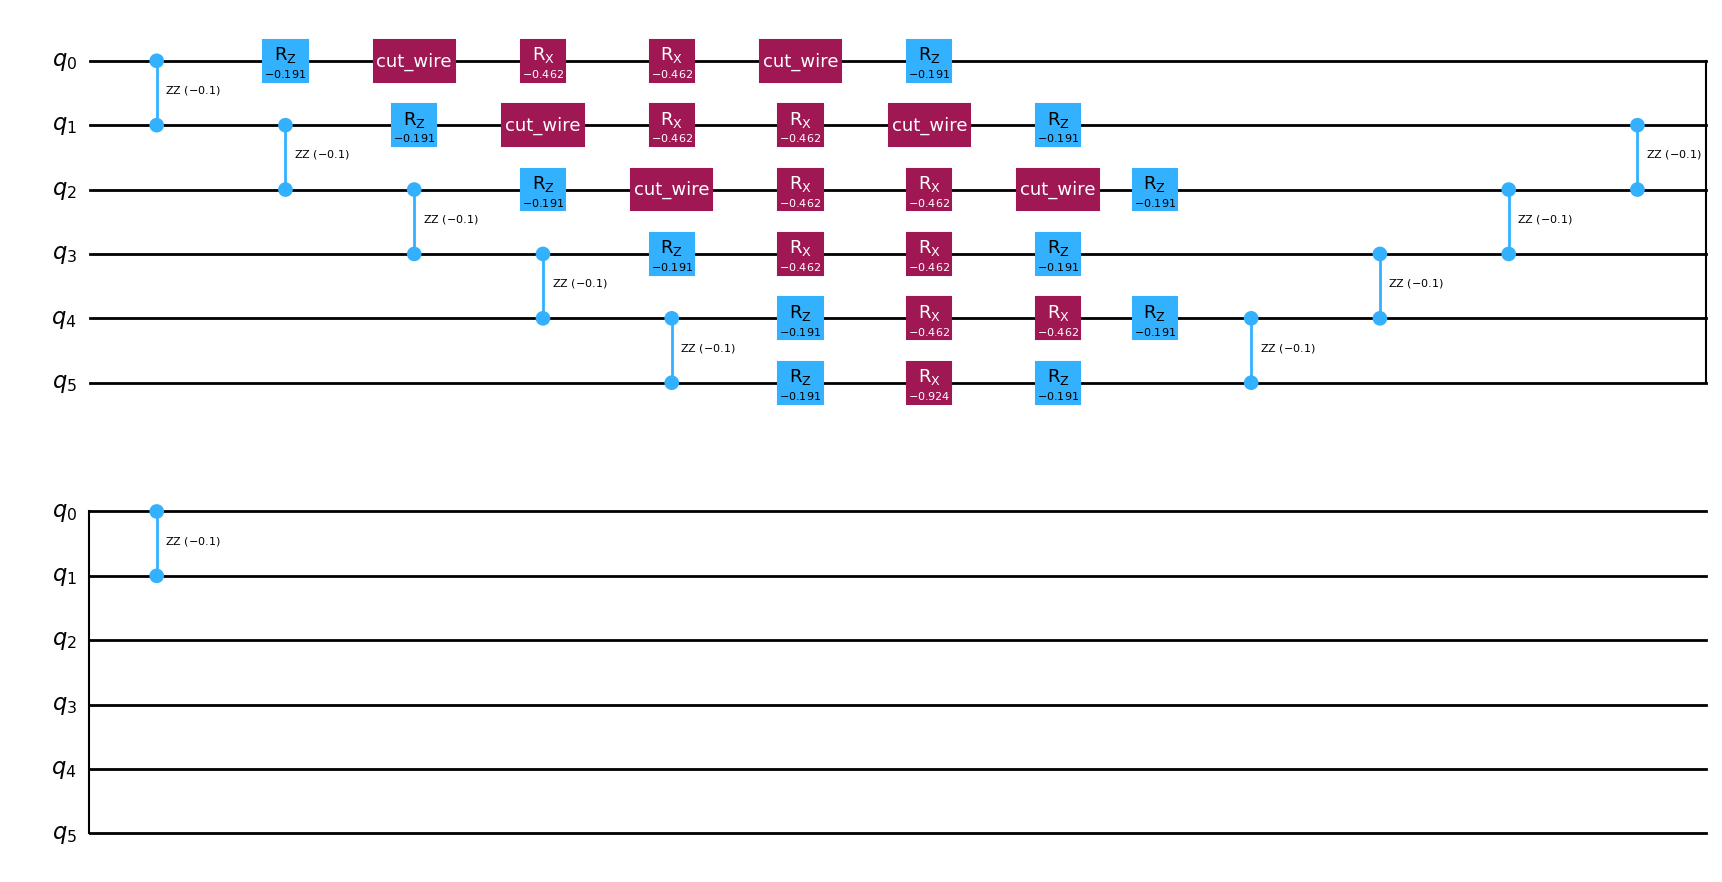

In [129]:
from qiskit.circuit.quantumregister import QuantumRegister, Qubit
from qiskit.circuit import CircuitInstruction, Instruction
temp = circuit.copy()
# cut_loc = [2,5,9,12,16,19,23,26,30,33,36,38]
cut_loc = [2,5,9,12,16,19]
for i in cut_loc:
    temp.data.insert(i, CircuitInstruction(operation=Instruction(name='cut_wire', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(6, 'q'), i//7),), clbits=()))
temp.draw("mpl")

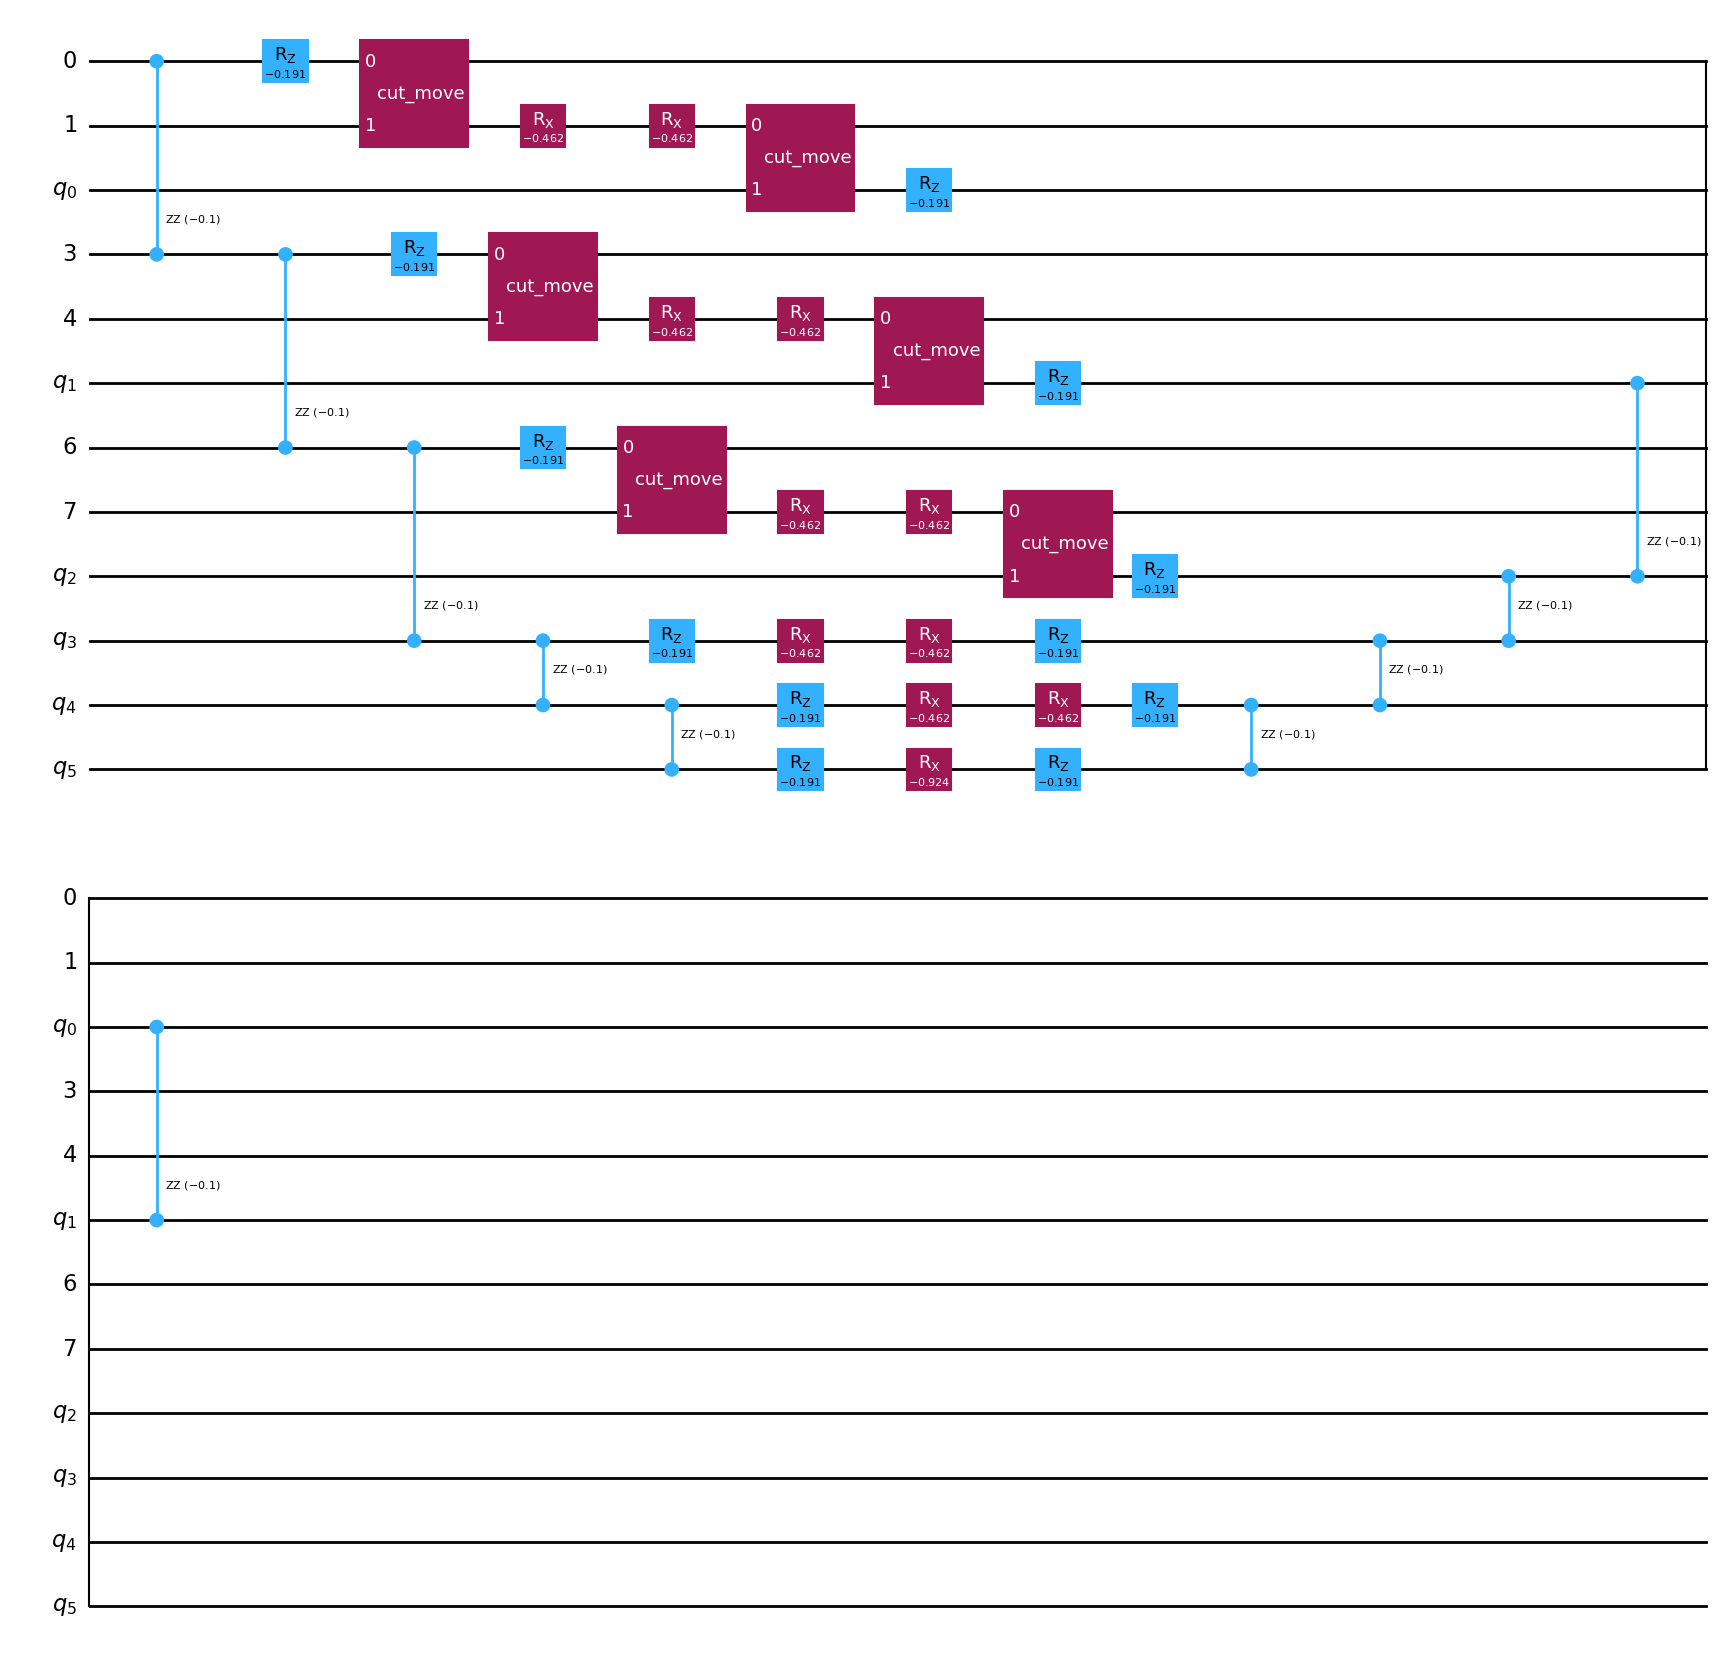

In [130]:
manual_cut = cut_wires(temp)
manual_cut.draw("mpl")

In [131]:
observable_expanded_paulis = expand_observables(observable.paulis, temp, manual_cut)
observable_expanded_paulis

PauliList(['IIIIIIIIIZII', 'IIIIIIZIIIII', 'IIIZIIIIIIII',
           'IIZIIIIIIIII', 'IZIIIIIIIIII', 'ZIIIIIIIIIII'])

In [132]:
partitioned_problem_m = partition_problem(
    circuit=manual_cut, observables=observable_expanded_paulis
)
msubcircuits = partitioned_problem_m.subcircuits
msubobservables = partitioned_problem_m.subobservables

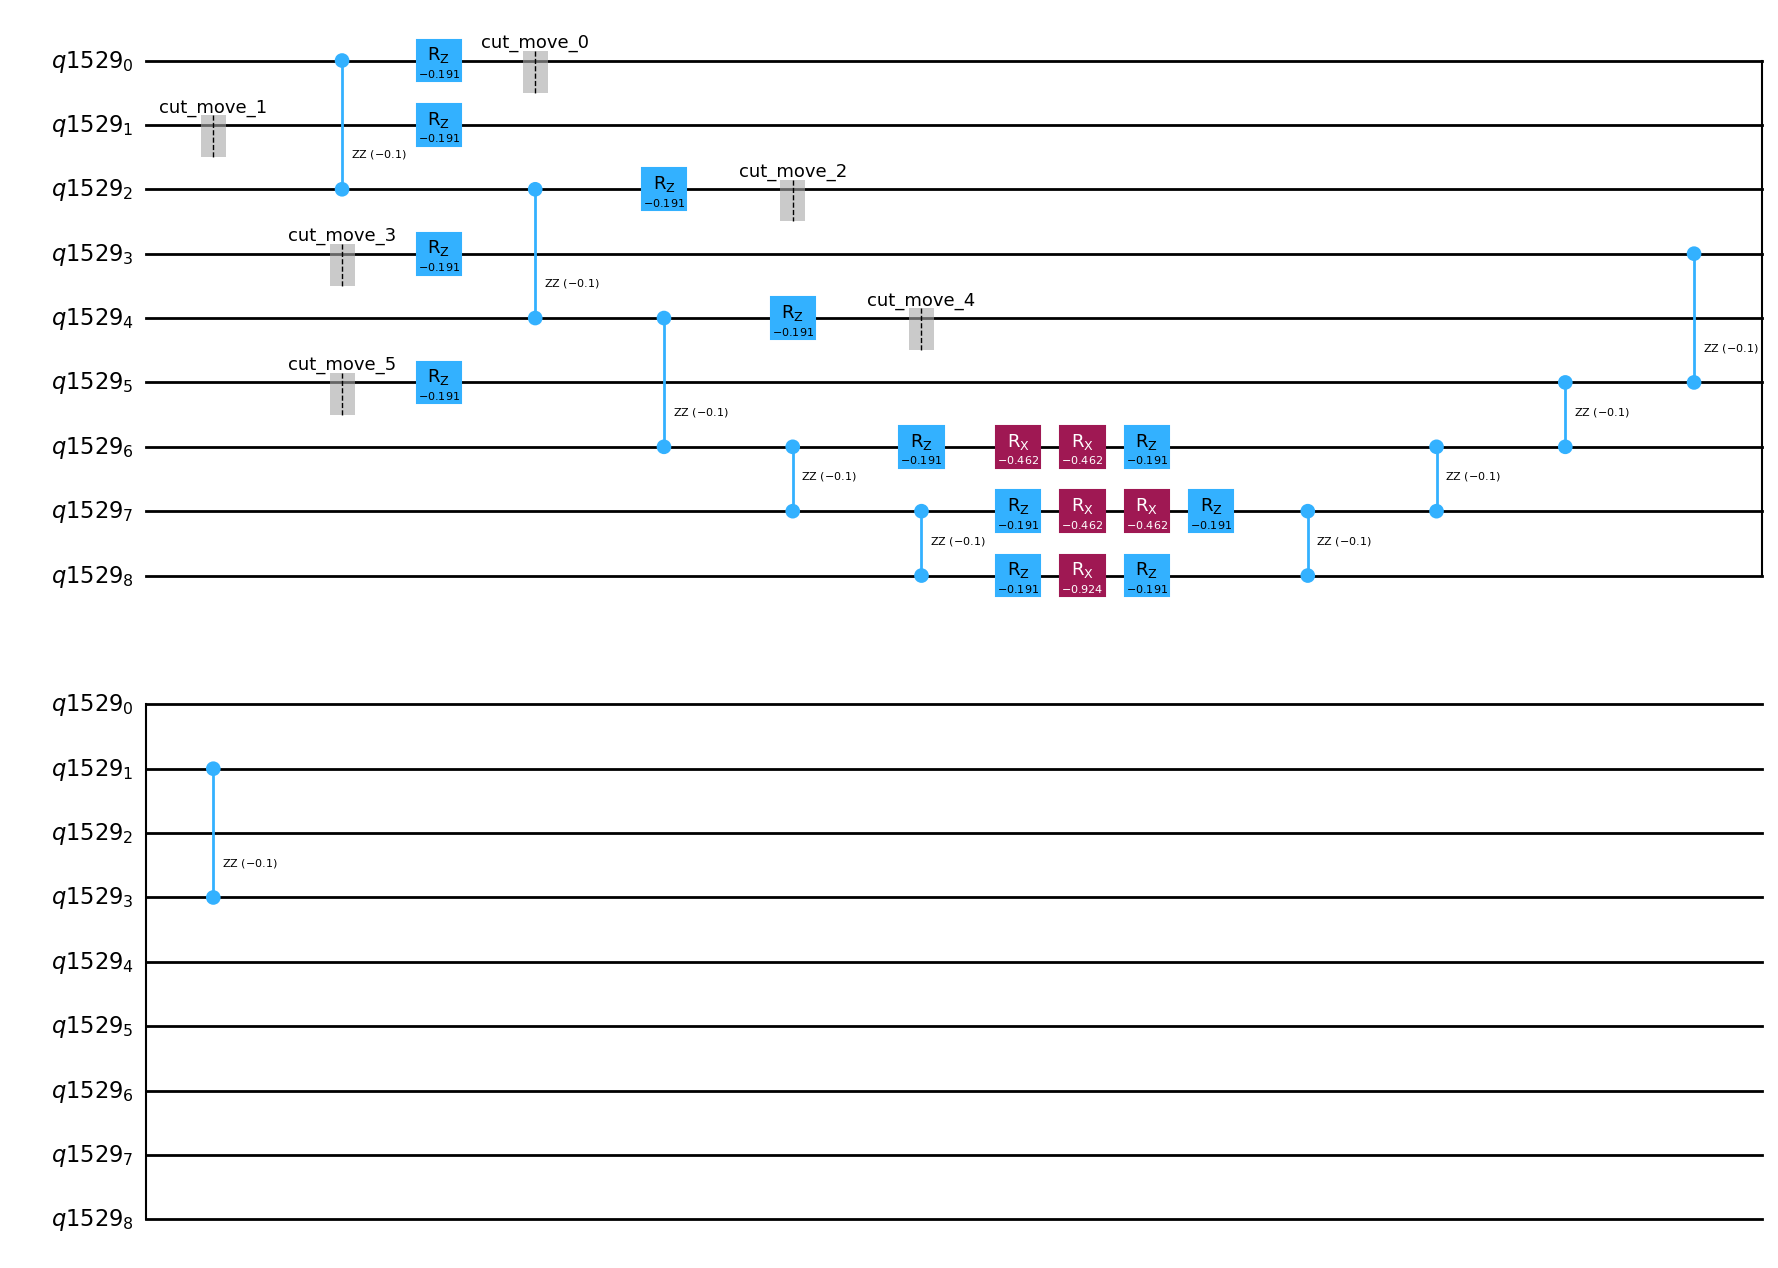

In [133]:
msubcircuits[0].draw("mpl")

In [134]:
msubexperiments, mcoefficients = generate_cutting_experiments(
    circuits=msubcircuits,
    observables=msubobservables,
    num_samples=np.inf,
)

In [140]:
from qiskit_ibm_runtime.fake_provider import FakeMelbourneV2

backend = FakeMelbourneV2()

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Transpile the subexperiments to ISA circuits
pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)
isa_subexperiments = {
    label: pass_manager.run(partition_subexpts)
    for label, partition_subexpts in msubexperiments.items()
}

from qiskit_ibm_runtime import SamplerV2, Batch

# Submit each partition's subexperiments to the Qiskit Runtime Sampler
# primitive, in a single batch so that the jobs will run back-to-back.
with Batch(backend=backend) as batch:
    sampler = SamplerV2(mode=batch)
    jobs = {
        label: sampler.run(subsystem_subexpts, shots=2**12)
        for label, subsystem_subexpts in isa_subexperiments.items()
    }

KeyboardInterrupt: 

In [138]:
print(
    f"Sampling overhead: {np.prod([basis.overhead for basis in partitioned_problem_m.bases])}"
)

Sampling overhead: 16777216.0


In [ ]:
# Retrieve the results
mresults = jobs.result()
reconstructed_expvals_m = reconstruct_expectation_values(
    mresults,
    mcoefficients,
    msubobservables,
)
mfinal_expval = np.dot(reconstructed_expvals_m, observable.coeffs)

In [ ]:
estimator = EstimatorV2()
exact_expval = (
    estimator.run([(temp.decompose("cut_wire"), observable)]).result()[0].data.evs
)
print(f"Reconstructed expectation value: {np.real(np.round(mfinal_expval, 8))}")
print(f"Exact expectation value: {np.round(exact_expval, 8)}")
print(f"Error in estimation: {np.real(np.round(mfinal_expval-exact_expval, 8))}")
print(
    f"Relative error in estimation: {np.real(np.round((mfinal_expval-exact_expval) / exact_expval, 8))}"
)

 # Resource Estimation

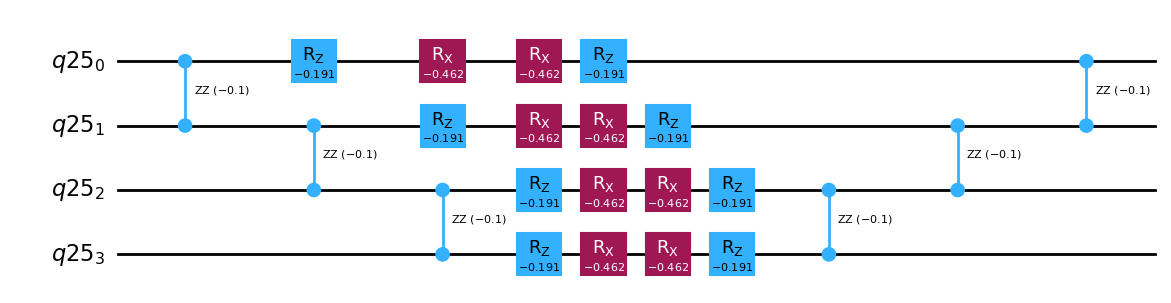

In [19]:
subA = subcircuits[0]
subA.data = [instruction for instruction in subcircuits[0].data if instruction.operation.name!='qpd_1q']
subA.draw("mpl")

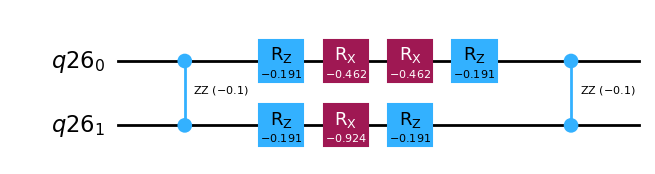

In [20]:
subB = subcircuits[1]
subB.data = [instruction for instruction in subcircuits[1].data if instruction.operation.name!='qpd_1q']
subB.draw("mpl")

In [21]:
job = backend_est.run(circuit)
result = job.result()
result

.......

Runtime,1 millisecs,"Total runtime This is a runtime estimate for the execution time of the algorithm. In general, the execution time corresponds to the duration of one logical cycle (4,400 nanosecs) multiplied by the 243 logical cycles to run the algorithm. If however the duration of a single T factory (here: 57,200 nanosecs) is larger than the algorithm runtime, we extend the number of logical cycles artificially in order to exceed the runtime of a single T factory."
rQOPS,4.55M,"Reliable quantum operations per second The value is computed as the number of logical qubits after layout (20) (with a logical error rate of 6.86e-8) multiplied by the clock frequency (227,272.73), which is the number of logical cycles per second."
Physical qubits,266.20k,"Number of physical qubits This value represents the total number of physical qubits, which is the sum of 4,840 physical qubits to implement the algorithm logic, and 261,360 physical qubits to execute the T factories that are responsible to produce the T states that are consumed by the algorithm."
Logical algorithmic qubits,20,"Number of logical qubits for the algorithm after layout Laying out the logical qubits in the presence of nearest-neighbor constraints requires additional logical qubits. In particular, to layout the $Q_{\rm alg} = 6$ logical qubits in the input algorithm, we require in total $2 \cdot Q_{\rm alg} + \lceil \sqrt{8 \cdot Q_{\rm alg}}\rceil + 1 = 20$ logical qubits."
Algorithmic depth,243,"Number of logical cycles for the algorithm To execute the algorithm using Parallel Synthesis Sequential Pauli Computation (PSSPC), operations are scheduled in terms of multi-qubit Pauli measurements, for which assume an execution time of one logical cycle. Based on the input algorithm, we require one multi-qubit measurement for the 0 single-qubit measurements, the 33 arbitrary single-qubit rotations, and the 0 T gates, three multi-qubit measurements for each of the 0 CCZ and 0 CCiX gates in the input program, as well as 15 multi-qubit measurements for each of the 14 non-Clifford layers in which there is at least one single-qubit rotation with an arbitrary angle rotation."
Logical depth,243,"Number of logical cycles performed This number is usually equal to the logical depth of the algorithm, which is 243. However, in the case in which a single T factory is slower than the execution time of the algorithm, we adjust the logical cycle depth to exceed the T factory's execution time."
Clock frequency,227.27k,Number of logical cycles per second This is the number of logical cycles that can be performed within one second. The logical cycle time is 4 microsecs.
Number of T states,495,"Number of T states consumed by the algorithm To execute the algorithm, we require one T state for each of the 0 T gates, four T states for each of the 0 CCZ and 0 CCiX gates, as well as 15 for each of the 33 single-qubit rotation gates with arbitrary angle rotation."
Number of T factories,27,"Number of T factories capable of producing the demanded 495 T states during the algorithm's runtime The total number of T factories 27 that are executed in parallel is computed as $\left\lceil\dfrac{\text{T states}\cdot\text{T factory duration}}{\text{T states per T factory}\cdot\text{algorithm runtime}}\right\rceil = \left\lceil\dfrac{495 \cdot 57,200\;\text{ns}}{1 \cdot 1,069,200\;\text{ns}}\right\rceil$"
Number of T factory invocations,19,"Number of times all T factories are invoked In order to prepare the 495 T states, the 27 copies of the T factory are repeatedly invoked 19 times."
Physical algorithmic qubits,4.84k,"Number of physical qubits for the algorithm after layout The 4,840 are the product of the 20 logical qubits after layout and the 242 physical qubits that encode a single logical qubit."


In [22]:
jobA = backend_est.run(subA)
resultA = jobA.result()
resultA

......

Runtime,713 microsecs,"Total runtime This is a runtime estimate for the execution time of the algorithm. In general, the execution time corresponds to the duration of one logical cycle (4,400 nanosecs) multiplied by the 162 logical cycles to run the algorithm. If however the duration of a single T factory (here: 57,200 nanosecs) is larger than the algorithm runtime, we extend the number of logical cycles artificially in order to exceed the runtime of a single T factory."
rQOPS,3.41M,"Reliable quantum operations per second The value is computed as the number of logical qubits after layout (15) (with a logical error rate of 1.37e-7) multiplied by the clock frequency (227,272.73), which is the number of logical cycles per second."
Physical qubits,245.63k,"Number of physical qubits This value represents the total number of physical qubits, which is the sum of 3,630 physical qubits to implement the algorithm logic, and 242,000 physical qubits to execute the T factories that are responsible to produce the T states that are consumed by the algorithm."
Logical algorithmic qubits,15,"Number of logical qubits for the algorithm after layout Laying out the logical qubits in the presence of nearest-neighbor constraints requires additional logical qubits. In particular, to layout the $Q_{\rm alg} = 4$ logical qubits in the input algorithm, we require in total $2 \cdot Q_{\rm alg} + \lceil \sqrt{8 \cdot Q_{\rm alg}}\rceil + 1 = 15$ logical qubits."
Algorithmic depth,162,"Number of logical cycles for the algorithm To execute the algorithm using Parallel Synthesis Sequential Pauli Computation (PSSPC), operations are scheduled in terms of multi-qubit Pauli measurements, for which assume an execution time of one logical cycle. Based on the input algorithm, we require one multi-qubit measurement for the 0 single-qubit measurements, the 22 arbitrary single-qubit rotations, and the 0 T gates, three multi-qubit measurements for each of the 0 CCZ and 0 CCiX gates in the input program, as well as 14 multi-qubit measurements for each of the 10 non-Clifford layers in which there is at least one single-qubit rotation with an arbitrary angle rotation."
Logical depth,162,"Number of logical cycles performed This number is usually equal to the logical depth of the algorithm, which is 162. However, in the case in which a single T factory is slower than the execution time of the algorithm, we adjust the logical cycle depth to exceed the T factory's execution time."
Clock frequency,227.27k,Number of logical cycles per second This is the number of logical cycles that can be performed within one second. The logical cycle time is 4 microsecs.
Number of T states,308,"Number of T states consumed by the algorithm To execute the algorithm, we require one T state for each of the 0 T gates, four T states for each of the 0 CCZ and 0 CCiX gates, as well as 14 for each of the 22 single-qubit rotation gates with arbitrary angle rotation."
Number of T factories,25,"Number of T factories capable of producing the demanded 308 T states during the algorithm's runtime The total number of T factories 25 that are executed in parallel is computed as $\left\lceil\dfrac{\text{T states}\cdot\text{T factory duration}}{\text{T states per T factory}\cdot\text{algorithm runtime}}\right\rceil = \left\lceil\dfrac{308 \cdot 57,200\;\text{ns}}{1 \cdot 712,800\;\text{ns}}\right\rceil$"
Number of T factory invocations,13,"Number of times all T factories are invoked In order to prepare the 308 T states, the 25 copies of the T factory are repeatedly invoked 13 times."
Physical algorithmic qubits,3.63k,"Number of physical qubits for the algorithm after layout The 3,630 are the product of the 15 logical qubits after layout and the 242 physical qubits that encode a single logical qubit."


In [23]:
jobB = backend_est.run(subB)
resultB = jobB.result()
resultB

......

Runtime,335 microsecs,"Total runtime This is a runtime estimate for the execution time of the algorithm. In general, the execution time corresponds to the duration of one logical cycle (3,600 nanosecs) multiplied by the 93 logical cycles to run the algorithm. If however the duration of a single T factory (here: 46,800 nanosecs) is larger than the algorithm runtime, we extend the number of logical cycles artificially in order to exceed the runtime of a single T factory."
rQOPS,2.50M,"Reliable quantum operations per second The value is computed as the number of logical qubits after layout (9) (with a logical error rate of 3.98e-7) multiplied by the clock frequency (277,777.78), which is the number of logical cycles per second."
Physical qubits,118.10k,"Number of physical qubits This value represents the total number of physical qubits, which is the sum of 1,458 physical qubits to implement the algorithm logic, and 116,640 physical qubits to execute the T factories that are responsible to produce the T states that are consumed by the algorithm."
Logical algorithmic qubits,9,"Number of logical qubits for the algorithm after layout Laying out the logical qubits in the presence of nearest-neighbor constraints requires additional logical qubits. In particular, to layout the $Q_{\rm alg} = 2$ logical qubits in the input algorithm, we require in total $2 \cdot Q_{\rm alg} + \lceil \sqrt{8 \cdot Q_{\rm alg}}\rceil + 1 = 9$ logical qubits."
Algorithmic depth,93,"Number of logical cycles for the algorithm To execute the algorithm using Parallel Synthesis Sequential Pauli Computation (PSSPC), operations are scheduled in terms of multi-qubit Pauli measurements, for which assume an execution time of one logical cycle. Based on the input algorithm, we require one multi-qubit measurement for the 0 single-qubit measurements, the 9 arbitrary single-qubit rotations, and the 0 T gates, three multi-qubit measurements for each of the 0 CCZ and 0 CCiX gates in the input program, as well as 14 multi-qubit measurements for each of the 6 non-Clifford layers in which there is at least one single-qubit rotation with an arbitrary angle rotation."
Logical depth,93,"Number of logical cycles performed This number is usually equal to the logical depth of the algorithm, which is 93. However, in the case in which a single T factory is slower than the execution time of the algorithm, we adjust the logical cycle depth to exceed the T factory's execution time."
Clock frequency,277.78k,Number of logical cycles per second This is the number of logical cycles that can be performed within one second. The logical cycle time is 4 microsecs.
Number of T states,126,"Number of T states consumed by the algorithm To execute the algorithm, we require one T state for each of the 0 T gates, four T states for each of the 0 CCZ and 0 CCiX gates, as well as 14 for each of the 9 single-qubit rotation gates with arbitrary angle rotation."
Number of T factories,18,"Number of T factories capable of producing the demanded 126 T states during the algorithm's runtime The total number of T factories 18 that are executed in parallel is computed as $\left\lceil\dfrac{\text{T states}\cdot\text{T factory duration}}{\text{T states per T factory}\cdot\text{algorithm runtime}}\right\rceil = \left\lceil\dfrac{126 \cdot 46,800\;\text{ns}}{1 \cdot 334,800\;\text{ns}}\right\rceil$"
Number of T factory invocations,7,"Number of times all T factories are invoked In order to prepare the 126 T states, the 18 copies of the T factory are repeatedly invoked 7 times."
Physical algorithmic qubits,1.46k,"Number of physical qubits for the algorithm after layout The 1,458 are the product of the 9 logical qubits after layout and the 162 physical qubits that encode a single logical qubit."


In [27]:
import qsharp

from qsharp_widgets import EstimatesOverview

items = [ 
    {"qubitParams": {"name": "qubit_gate_ns_e3"}, "errorBudget": 0.0001}, 
    {"qubitParams": {"name": "qubit_gate_ns_e4"}, "errorBudget": 0.0001}, 
] # target parameters 

job = backend_est.run(circuit, items=items) 
results = job.result() 
EstimatesOverview(results, colors=["#1f77b4", "#ff7f0e"], runNames=["e3 Surface Code", "e4 Surface Code"])

......

EstimatesOverview(colors=['#1f77b4', '#ff7f0e'], estimates={0: {'status': 'success', 'jobParams': {'qecScheme'…

In [29]:
items = [ 
    {"qubitParams": {"name": "qubit_gate_ns_e3"}, "errorBudget": 0.0001, "estimateType": "frontier",}, 
    {"qubitParams": {"name": "qubit_gate_ns_e4"}, "errorBudget": 0.0001, "estimateType": "frontier",}, 
] # target parameters 

job = backend_est.run(circuit, items=items) 
results = job.result() 
EstimatesOverview(results, colors=["#1f77b4", "#ff7f0e"], runNames=["e3 Surface Code", "e4 Surface Code"])

........

EstimatesOverview(colors=['#1f77b4', '#ff7f0e'], estimates={0: {'status': 'success', 'jobParams': {'qecScheme'…

In [37]:
items = [ 
    {"qubitParams": {"name": "qubit_gate_ns_e3"}, "errorBudget": 0.0001, "estimateType": "frontier", "constraints":{"logicalDepthFactor":1.5, "maxTFactories":10},}, 
    {"qubitParams": {"name": "qubit_gate_ns_e4"}, "errorBudget": 0.0001, "estimateType": "frontier","constraints":{"logicalDepthFactor":1.5, "maxTFactories":10},}, 
] # target parameters 

job = backend_est.run(circuit, items=items) 
results = job.result() 
EstimatesOverview(results, colors=["#1f77b4", "#ff7f0e"], runNames=["e3 Surface Code", "e4 Surface Code"])

.......

EstimatesOverview(colors=['#1f77b4', '#ff7f0e'], estimates={0: {'status': 'success', 'jobParams': {'qecScheme'…

In [36]:
items = [ 
    {"qubitParams": { "name": "qubit_maj_ns_e4" },
    "qecScheme": { "name": "surface_code" },
    "estimateType": "frontier", # Pareto frontier estimation
                    }
] # target parameters 

job = backend_est.run(circuit, items=items)
result = job.result()
EstimatesOverview(result)

......

EstimatesOverview(estimates={'status': 'success', 'jobParams': {'qecScheme': {'name': 'surface_code', 'errorCo…